In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import bt_mle_utils as mle
import random

In [2]:
########################## simulations #############################

def get_beta_with_gap(N, delta = 0.1):
    beta = np.arange(N) * delta
    beta = beta - np.mean(beta)
    return beta

def get_p(beta):
    N = len(beta.reshape(-1))
    pij = np.zeros((N,N))
    p = np.zeros(N)
    for i in range(N):
        for j in range(N):
            if j == i:
                continue
            pij[i][j] = np.exp(beta[i] - beta[j]) / (1 + np.exp(beta[i] - beta[j]))
            p[i] += pij[i][j] / (N - 1)
    return p

def min_gap_pi(beta):
    N = len(beta.reshape(-1))
    p = get_p(beta)
    p_sort = np.sort(p)
    min_gap = float('inf')
    for i in range(1,N):
        min_gap = min(min_gap, p_sort[i] - p_sort[i - 1])
    return min_gap

def topk_gap_pi(beta, k = None):
    N = len(beta.reshape(-1))
    if not k:
        k = N // 2
    p = get_p(beta)
    p_sort = np.sort(p)
    topk_gap = float('inf')
    topk_gap = p_sort[-k] - p_sort[- k - 1]
    return topk_gap

def get_game_matrix_single_time(beta, total):
    game_matrix = np.zeros(N * N).reshape(N,N)
    for i in range(N):
        for j in range(i + 1,N):
            pij = np.exp(beta[i] - beta[j]) / (1 + np.exp(beta[i] - beta[j]))
            nij = np.random.binomial(n = total, p = pij, size = 1)
            game_matrix[i,j], game_matrix[j,i] = nij, total - nij
    return game_matrix 

########################## estimators #############################

def get_p_hat(game_matrix):
    n, _ = game_matrix.shape
    p_hat_ij = np.zeros((n,n))
    p_hat_i = np.zeros(n)
    for i in range(n):
        pair = 0
        for j in range(n):
            if j == i:
                continue
            t_ij = game_matrix[i][j] + game_matrix[j][i]
            if t_ij > 0:
                pair += 1
                p_hat_ij[i][j] = game_matrix[i][j] / t_ij
                p_hat_i[i] += p_hat_ij[i][j]
        p_hat_i[i] /= pair
    return p_hat_i

def get_mle_reg(game_matrix, lam = None):
    n, _ = game_matrix.shape
    total = np.max(game_matrix + game_matrix.T)
    if not lam:
        lam = (n * np.log(n) / total)**0.5
    beta_hat = mle.newton_l2_sq(Y, l_penalty = 1)[1].reshape(-1)
    beta_hat -= np.mean(beta_hat)
    
    return beta_hat

########################## metrics #############################

def ranking_error(v,v_hat):
    r = stats.rankdata(v, method = 'min')
    r_hat = stats.rankdata(v_hat, method = 'min')
    return np.sum(np.abs(r - r_hat))

def topk_error(v, v_hat, k = None):
    n = len(v)
    if not k:
        k = n // 3
    r = stats.rankdata(v, method = 'min')
    r_hat = stats.rankdata(v_hat, method = 'min')
    
    ind = np.arange(1, n + 1)
    top = np.where(r <= k)[0]
    bottom = np.setdiff1d(ind, top)
    top_hat = np.where(r_hat <= k)[0]
    bottom_hat = np.setdiff1d(ind, top_hat)
    
    diff = len(np.setdiff1d(top,top_hat)) + len(np.setdiff1d(bottom,bottom_hat))
    diff /= (2 * k)  

    ## test
    ## a1 = [1,2,3]
    ## a2 = [3,2,1]
    ## topk_error(a1,a2)
    return diff

def get_error(v, v_hat, k = None):
    l1 = np.mean(np.abs(v - v_hat)) / np.sum(np.abs(v))
    rank = ranking_error(v, v_hat)
    topk = topk_error(v, v_hat, k = k)
    return l1, rank, topk

---

In [28]:
p1, p2 = 0.1, 0.5
n1, n2 = 50, 50
p = np.concatenate([np.ones(n1) * p1, np.ones(n2) * p2])
pv = p.reshape((-1,1))
La = np.sum(p) * np.diag(p) - pv @ pv.T

In [27]:
np.diag(p)

array([[0.1, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.1, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.1, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.5, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.5, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0.5]])

In [30]:
lambdas = np.linalg.eigvalsh(La)

In [31]:
lambdas

array([-6.9388939e-17,  3.0000000e+00,  3.0000000e+00,  3.0000000e+00,
        3.0000000e+00,  3.0000000e+00,  3.0000000e+00,  3.0000000e+00,
        3.0000000e+00,  3.0000000e+00,  3.0000000e+00,  3.0000000e+00,
        3.0000000e+00,  3.0000000e+00,  3.0000000e+00,  3.0000000e+00,
        3.0000000e+00,  3.0000000e+00,  3.0000000e+00,  3.0000000e+00,
        3.0000000e+00,  3.0000000e+00,  3.0000000e+00,  3.0000000e+00,
        3.0000000e+00,  3.0000000e+00,  3.0000000e+00,  3.0000000e+00,
        3.0000000e+00,  3.0000000e+00,  3.0000000e+00,  3.0000000e+00,
        3.0000000e+00,  3.0000000e+00,  3.0000000e+00,  3.0000000e+00,
        3.0000000e+00,  3.0000000e+00,  3.0000000e+00,  3.0000000e+00,
        3.0000000e+00,  3.0000000e+00,  3.0000000e+00,  3.0000000e+00,
        3.0000000e+00,  3.0000000e+00,  3.0000000e+00,  3.0000000e+00,
        3.0000000e+00,  3.0000000e+00,  5.0000000e+00,  1.5000000e+01,
        1.5000000e+01,  1.5000000e+01,  1.5000000e+01,  1.5000000e+01,
      

## Barbell

In [271]:
np.tile(np.arange(3),2)

array([0, 1, 2, 0, 1, 2])

In [272]:
np.repeat(np.arange(3),2)

array([0, 0, 1, 1, 2, 2])

In [4]:
def get_complete_adj(n = 50):
    return np.ones((n,n)) - np.eye(n)

def random_edge(n1, n2, edge):
    index = np.random.choice(n1 * n2, edge, replace = False)
    i1 = np.repeat(np.arange(n1), n2)[index]
    i2 = np.tile(np.arange(n1), n2)[index]    
    A = np.zeros((n1, n2))
    A[i1,i2] = 1
    return A

def get_barbell_adj(n1 = 50, n2 = 50, bridge = 1):
    n = n1 + n2
    A = np.zeros((n,n))
    A[:n1,:n1] = get_complete_adj(n = n1)
    A[n1:,n1:] = get_complete_adj(n = n2)
    A[:n1,n1:] = random_edge(n1 = n1, n2 = n2, edge = bridge)
    A[n1:,:n1] = A[:n1,n1:].copy().T
    return A

def lambda2_A(A):
    n = A.shape[0]
    La = np.diag(np.sum(A, axis = 0)) - A
    lambdas = np.linalg.eigvalsh(La)
    return lambdas[1], lambdas[-1]

def min_n_ij(A):
    return np.min(A @ A)

In [283]:
E = random_edge(5,5,10)
np.sum(E)

10.0

In [289]:
A = get_barbell_adj(n1 = 3, n2 = 5, bridge = 1)
A

array([[0., 1., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1., 0., 1., 1.],
       [0., 0., 0., 1., 1., 1., 0., 1.],
       [0., 0., 0., 1., 1., 1., 1., 0.]])

In [294]:
e = np.where(A)
a = zip(e[0],e[1])
for i in a:
    print(i)

(0, 1)
(0, 2)
(1, 0)
(1, 2)
(2, 0)
(2, 1)
(2, 5)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(4, 3)
(4, 5)
(4, 6)
(4, 7)
(5, 2)
(5, 3)
(5, 4)
(5, 6)
(5, 7)
(6, 3)
(6, 4)
(6, 5)
(6, 7)
(7, 3)
(7, 4)
(7, 5)
(7, 6)


In [291]:
np.triu(np.ones((3,3)))

array([[1., 1., 1.],
       [0., 1., 1.],
       [0., 0., 1.]])

In [285]:
n1, n2 = 50, 50
bridge_list = np.arange(50) * 50
lam2_list = []
min_n_ij_list = []
B = 10
for bridge in bridge_list:
    lam, n_ij = 0, 0
    for b in range(B):
        A = get_barbell_adj(n1 = n1, n2 = n2, bridge = bridge)
        lam2, lamn = lambda2_A(A)
        lam += lam2 / B
        n_ij += min_n_ij(A) / B
    lam2_list.append(lam)
    min_n_ij_list.append(n_ij)
lam2_list = np.array(lam2_list)
min_n_ij_list = np.array(min_n_ij_list)

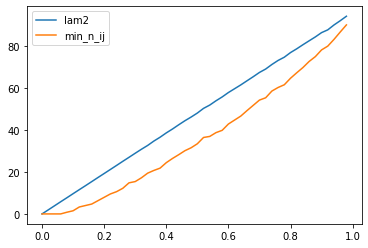

In [286]:
plt.plot(bridge_list / (n1 * n2), lam2_list)
plt.plot(bridge_list / (n1 * n2), min_n_ij_list)
plt.legend(['lam2','min_n_ij'])

In [288]:
A

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [5]:
def get_barbell_edge(n1 = 50, n2 = 50, bridge = 1):
    n = n1 + n2
    A = get_barbell_adj(n1 = n1, n2 = n2, bridge = bridge)
    edge = np.where(np.triu(A))
    return zip(edge[0], edge[1])

def get_edge(A):
    edge = np.where(np.triu(A))
    return zip(edge[0], edge[1])

In [123]:
def get_beta_with_gap(N, delta = 0.1):
    beta = np.arange(N) * delta
    beta = beta - np.mean(beta)
    return beta

def get_game_matrix(beta, edge_list, total = 1):
    N = len(beta)
    game_matrix = np.zeros((N,N))
    for edge in edge_list:
        i, j = edge
        pij = np.exp(beta[i] - beta[j]) / (1 + np.exp(beta[i] - beta[j]))
        nij = np.random.binomial(n = total, p = pij, size = 1)
        game_matrix[i,j], game_matrix[j,i] = nij, total - nij
    return game_matrix

def get_mle_reg(game_matrix, rho = None):
    n, _ = game_matrix.shape
    total = np.max(game_matrix + game_matrix.T)
    if not rho:
        rho = (n * np.log(n) / total)**0.5
    beta_hat = mle.newton_l2_sq(game_matrix, l_penalty = rho)[1].reshape(-1)
    beta_hat -= np.mean(beta_hat)
    
    return beta_hat

def l0_error(v, v_hat):
    return np.max(np.abs(v - v_hat))

def ranking_error(v,v_hat):
    r = stats.rankdata(v, method = 'min')
    r_hat = stats.rankdata(v_hat, method = 'min')
    return np.sum(np.abs(r - r_hat))

def topk_error(v, v_hat, k = None):
    n = len(v)
    if not k:
        k = n // 3
    r = stats.rankdata(v, method = 'min')
    r_hat = stats.rankdata(v_hat, method = 'min')
    
    ind = np.arange(1, n + 1)
    top = np.where(r <= k)[0]
    bottom = np.setdiff1d(ind, top)
    top_hat = np.where(r_hat <= k)[0]
    bottom_hat = np.setdiff1d(ind, top_hat)
    
    diff = len(np.setdiff1d(top,top_hat)) + len(np.setdiff1d(bottom,bottom_hat))
    diff /= (2 * k)  

    ## test
    ## a1 = [1,2,3]
    ## a2 = [3,2,1]
    ## topk_error(a1,a2)
    return diff

def get_error(v, v_hat, k = None):
    l0 = l0_error(v, v_hat)
    rank = ranking_error(v, v_hat)
    topk = topk_error(v, v_hat, k = k)
    return l0, rank, topk

def get_bound_yan(kappa, n_ij, n, L, no_kappa = False):
    if no_kappa:
        return 1 / n_ij * np.sqrt(L * n * np.log(n + 1))
    else:
        return np.exp(kappa) / n_ij * np.sqrt(L * n * np.log(n + 1))
    
def get_bound_shah(kappa, lam2, n, L, no_kappa = False):
    if no_kappa:
        return np.sqrt(1/lam2 * (n * np.log(n) / L))
    else:
        return np.exp(4 * kappa) * np.sqrt(1/lam2 * (n * np.log(n) / L))


def get_bound_our(kappa, lam2, n_max, n_min, n, L, no_kappa = False):
    if no_kappa:
        return 1/lam2 * (n_max/n_min) * np.sqrt(n / L) + 1/lam2 * np.sqrt(n_max * np.log(n) / L)
    else:
        return np.exp(2 * kappa)/lam2 * (n_max/n_min) * np.sqrt(n / L) + np.exp(kappa)/lam2 * np.sqrt(n_max * np.log(n) / L)

In [241]:
t = 0.9
kappa = np.log(t / (1 - t))
kappa

2.1972245773362196

In [243]:
np.exp(4 * kappa)

6561.000000000005

In [310]:
game_matrix.shape

(100, 100)

In [309]:
len(beta_hat)

50

In [7]:
def get_topo(A):
    lam2, lamn = lambda2_A(A)
    n_ij = min_n_ij(A)
    deg = np.sum(A, axis = 0)
    n_max, n_min = np.max(deg), np.min(deg)
    return lam2, n_ij, n_max, n_min

In [30]:
kappa = 2.1
np.exp(kappa) / (1 + np.exp(kappa))

0.8909031788043871

In [32]:
t = 0.9
np.log(t / (1 - t))

2.1972245773362196

In [148]:
n1, n2 = 50, 50
# bridge_list = np.arange(m) * 50
bridge_list = np.array([10, 25, 50, 75, 100, 200, 300, 400, 500, 800, 1200, 1600, 2000, 2400])
m = len(bridge_list)
B = 20

lam2_list = np.zeros(m)
min_n_ij_list = np.zeros(m)
n_max_list = np.zeros(m)
n_min_list = np.zeros(m)

bound_yan_list = np.zeros(m)
bound_shah_list = np.zeros(m)
bound_our_list = np.zeros(m)
bound_yan_nk_list = np.zeros(m)
bound_shah_nk_list = np.zeros(m)
bound_our_nk_list = np.zeros(m)

std_yan_list = np.zeros(m)
std_shah_list = np.zeros(m)
std_our_list = np.zeros(m)
std_yan_nk_list = np.zeros(m)
std_shah_nk_list = np.zeros(m)
std_our_nk_list = np.zeros(m)

bar_yan_list = np.zeros((m,2))
bar_shah_list = np.zeros((m,2))
bar_our_list = np.zeros((m,2))
bar_yan_nk_list = np.zeros((m,2))
bar_shah_nk_list = np.zeros((m,2))
bar_our_nk_list = np.zeros((m,2))

n = n1 + n2
# delta = np.log(n) / n
k = 10
t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta = get_beta_with_gap(n, delta)
beta *= kappa / (np.max(beta) - np.min(beta))
total = 5


l0_beta_list = np.zeros(m)
std_l0_beta_list = np.zeros(m)
bar_l0_beta_list = np.zeros((m,2))
rank_beta_list = np.zeros(m)
topk_beta_list = np.zeros(m)

np.random.seed(0)

for ix, bridge in enumerate(bridge_list):
    lam, n_ij = 0, 0
    
    l0_beta_, rank_beta_, topk_beta_ = np.zeros(B), np.zeros(B), np.zeros(B)
    lam2_, n_ij_, n_max_, n_min_ = np.zeros(B), np.zeros(B), np.zeros(B), np.zeros(B)
    bound_yan_, bound_shah_, bound_our_ = np.zeros(B), np.zeros(B), np.zeros(B)
    bound_yan_nk_, bound_shah_nk_, bound_our_nk_ = np.zeros(B), np.zeros(B), np.zeros(B)
    
    for b in range(B):
        A = get_barbell_adj(n1 = n1, n2 = n2, bridge = bridge)
        lam2_[b], n_ij_[b], n_max_[b], n_min_[b] = get_topo(A)
        
        edge_list = get_edge(A)
        game_matrix = get_game_matrix(beta, edge_list, total)
        
        beta_hat = get_mle_reg(game_matrix)
        l0_beta_[b], rank_beta_[b], topk_beta_[b] = get_error(beta, beta_hat, k = k)
        
        L = total
        bound_yan_[b] = get_bound_yan(kappa, n_ij_[b], n, L = total)
        bound_shah_[b] = get_bound_shah(kappa, lam2_[b], n, L = total)
        bound_our_[b] = get_bound_our(kappa, lam2_[b], n_max_[b], n_min_[b], n, L)
        
        bound_yan_nk_[b] = get_bound_yan(kappa, n_ij_[b], n, L = total, no_kappa = True)
        bound_shah_nk_[b] = get_bound_shah(kappa, lam2_[b], n, L = total, no_kappa = True)
        bound_our_nk_[b] = get_bound_our(kappa, lam2_[b], n_max_[b], n_min_[b], n, L, no_kappa = True)
        
        
        
    lam2_list[ix] = np.mean(lam2_)
    min_n_ij_list[ix] = np.mean(n_ij_)
    n_max_list[ix], n_min_list[ix] = np.mean(n_max_), np.mean(n_min_)
    bound_yan_list[ix] = np.mean(bound_yan_)
    bound_shah_list[ix] = np.mean(bound_shah_)
    bound_our_list[ix] = np.mean(bound_our_)
    bound_yan_nk_list[ix] = np.mean(bound_yan_nk_)
    bound_shah_nk_list[ix] = np.mean(bound_shah_nk_)
    bound_our_nk_list[ix] = np.mean(bound_our_nk_)
    
    std_yan_list[ix] = np.std(bound_yan_)
    std_shah_list[ix] = np.std(bound_shah_)
    std_our_list[ix] = np.std(bound_our_)
    std_yan_nk_list[ix] = np.std(bound_yan_nk_)
    std_shah_nk_list[ix] = np.std(bound_shah_nk_)
    std_our_nk_list[ix] = np.std(bound_our_nk_)
    
    bar_yan_list[ix,:] = np.quantile(bound_yan_, 0.05), np.quantile(bound_yan_, 0.95)
    bar_shah_list[ix, :] = np.quantile(bound_shah_, 0.05), np.quantile(bound_shah_, 0.95)
    bar_our_list[ix, :] = np.quantile(bound_our_, 0.05), np.quantile(bound_our_, 0.95)
    bar_yan_nk_list[ix, :] = np.quantile(bound_yan_nk_, 0.05), np.quantile(bound_yan_nk_, 0.95)
    bar_shah_nk_list[ix, :] = np.quantile(bound_shah_nk_, 0.05), np.quantile(bound_shah_nk_, 0.95)
    bar_our_nk_list[ix, :] = np.quantile(bound_our_nk_, 0.05), np.quantile(bound_our_nk_, 0.95)
    
    l0_beta_list[ix] = np.mean(l0_beta_)
    std_l0_beta_list[ix] = np.std(l0_beta_)
    bar_l0_beta_list[ix, :] = np.quantile(l0_beta_, 0.05), np.quantile(l0_beta_, 0.95)
    
    rank_beta_list = np.mean(rank_beta_)
    topk_beta_list = np.mean(topk_beta_)    
    
    print(bridge / (n1 * n2))

c:\python\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
c:\python\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in double_scalars
c:\python\lib\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\python\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


0.004
0.01
0.02
0.03
0.04
0.08
0.12
0.16
0.2
0.32
0.48
0.64
0.8
0.96


In [70]:
bound_yan_list

array([          inf,           inf,           inf,           inf,
                 inf,           inf, 1297.00093616,  640.67728783,
        426.02020167,  208.47379834,  108.83084738,   72.28964191,
         52.73630414,   39.89668645])

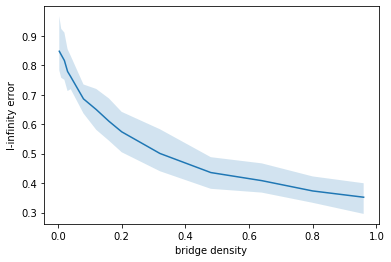

In [165]:
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l0_beta_list[:,0], bar_l0_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l0_beta_list)
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
plt.savefig('barbell-3.pdf')

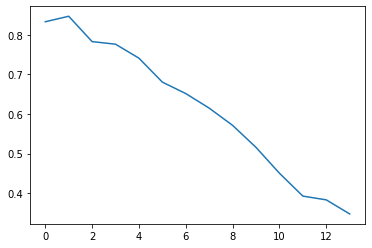

In [75]:
plt.plot(l0_beta_list)

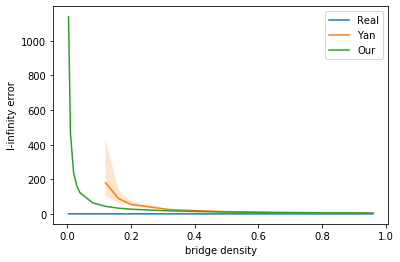

In [164]:
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l0_beta_list[:,0], bar_l0_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l0_beta_list)
plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
# plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.fill_between(bridge_list / (n1 * n2), bar_our_list[:,0], bar_our_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
# plt.legend(['Real','Yan','Shah','Our'])
plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
plt.savefig('barbell-1.pdf')

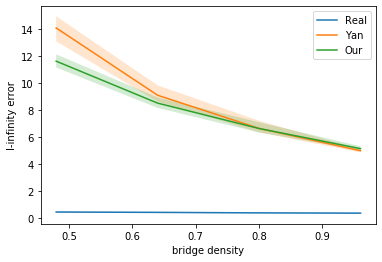

In [163]:
i = 10
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_l0_beta_list[i:,0], bar_l0_beta_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), l0_beta_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_yan_list[i:,0], bar_yan_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_yan_list[i:])
# plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_our_list[i:,0], bar_our_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_our_list[i:])
# plt.legend(['Real','Yan','Shah','Our'])
plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
plt.savefig('barbell-2.pdf')

Text(0, 0.5, 'l-infinity error')

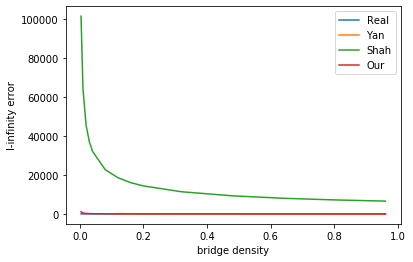

In [126]:
plt.plot(bridge_list / (n1 * n2), l0_beta_list)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
plt.legend(['Real','Yan','Shah','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

Text(0, 0.5, 'l-infinity error')

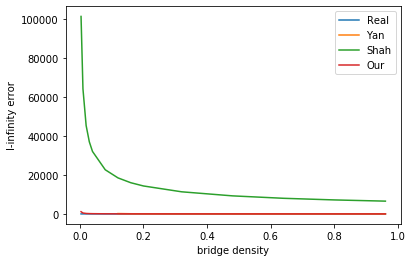

In [167]:
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l0_beta_list[:,0], bar_l0_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l0_beta_list)
plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
plt.fill_between(bridge_list / (n1 * n2), bar_shah_list[:,0], bar_shah_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.fill_between(bridge_list / (n1 * n2), bar_our_list[:,0], bar_our_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
plt.legend(['Real','Yan','Shah','Our'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

Text(0, 0.5, 'l-infinity error')

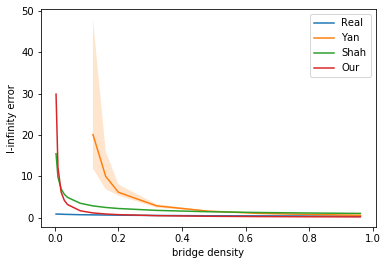

In [168]:
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l0_beta_list[:,0], bar_l0_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l0_beta_list)
plt.fill_between(bridge_list / (n1 * n2), bar_yan_nk_list[:,0], bar_yan_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_yan_nk_list)
plt.fill_between(bridge_list / (n1 * n2), bar_shah_nk_list[:,0], bar_shah_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_shah_nk_list)
plt.fill_between(bridge_list / (n1 * n2), bar_our_nk_list[:,0], bar_our_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_our_nk_list)
plt.legend(['Real','Yan','Shah','Our'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

In [77]:
len(bridge_list)

14

Text(0, 0.5, 'l-infinity error')

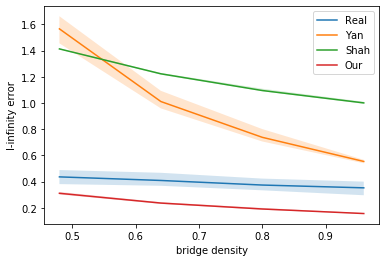

In [170]:
i = 10
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_l0_beta_list[i:,0], bar_l0_beta_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), l0_beta_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_yan_nk_list[i:,0], bar_yan_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_yan_nk_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_shah_nk_list[i:,0], bar_shah_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_shah_nk_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_our_nk_list[i:,0], bar_our_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_our_nk_list[i:])
plt.legend(['Real','Yan','Shah','Our'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

Text(0, 0.5, 'l-infinity error')

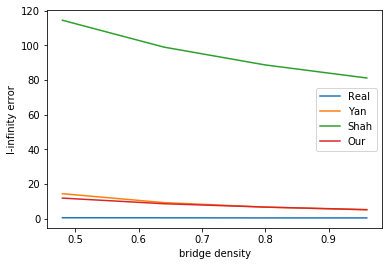

In [134]:
i = 10
plt.plot(bridge_list[i:] / (n1 * n2), l0_beta_list[i:])
plt.plot(bridge_list[i:] / (n1 * n2), bound_yan_list[i:])
plt.plot(bridge_list[i:] / (n1 * n2), bound_shah_nk_list[i:] * np.exp(2 * kappa))
plt.plot(bridge_list[i:] / (n1 * n2), bound_our_list[i:])
plt.legend(['Real','Yan','Shah','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-2.pdf')

In [203]:
def get_complete_adj(n = 50):
    return np.ones((n,n)) - np.eye(n)

def random_edge(n1, n2, edge):
    index = np.random.choice(n1 * n2, edge, replace = False)
    i1 = np.repeat(np.arange(n1), n2)[index]
    i2 = np.tile(np.arange(n1), n2)[index]    
    A = np.zeros((n1, n2))
    A[i1,i2] = 1
    return A

def get_3island_adj(n = 100, n1 = 30, n2 = 70, n3 = 30, k = None):
    if k is None:
        k = n1 // 2
    A = np.zeros((n,n))
    A[:n1,:n1] = get_complete_adj(n = n1)
    A[-n3:,-n3:] = get_complete_adj(n = n3)
    A[k:k+n2,k:k+n2] = get_complete_adj(n = n2)
    return A

def get_island_adj(ni = 30, no = 5, k = 5, n = None):
    if n == None:
        n = ni * k - no * (k - 1)
    else:
        k = n // (ni - no) + 1
    A = np.zeros((n,n))
    for i in range(k):
        s = (ni - no) * i
        e = min(n, s + ni)
        A[s:e,s:e] = get_complete_adj(n = e - s)
    return A

def lambda2_A(A):
    n = A.shape[0]
    La = np.diag(np.sum(A, axis = 0)) - A
    lambdas = np.linalg.eigvalsh(La)
    return lambdas[1], lambdas[-1]

def min_n_ij(A):
    return np.min(A @ A)

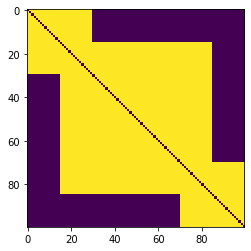

In [231]:
A = get_3island_adj()
plt.imshow(A)
plt.savefig('adj_3island.pdf')

In [232]:
min_n_ij(A)

0.0

In [233]:
lam2, lamn = lambda2_A(A)
lam2

11.921134470680464

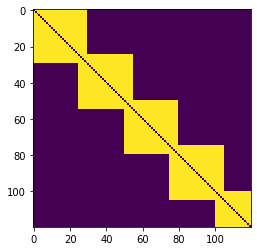

In [234]:
A = get_island_adj(n = 120)
plt.imshow(A)
plt.savefig('adj_island.pdf')

In [235]:
min_n_ij(A)

0.0

In [236]:
lam2, lamn = lambda2_A(A)
lam2

1.1929892762754417

In [244]:
ni = 30
# bridge_list = np.arange(m) * 50
theta_list = np.array([1,2,4,8,12,16,20])
m = len(theta_list)
B = 5

lam2_list = np.zeros(m)
min_n_ij_list = np.zeros(m)
n_max_list = np.zeros(m)
n_min_list = np.zeros(m)

bound_yan_list = np.zeros(m)
bound_shah_list = np.zeros(m)
bound_our_list = np.zeros(m)
bound_yan_nk_list = np.zeros(m)
bound_shah_nk_list = np.zeros(m)
bound_our_nk_list = np.zeros(m)

std_yan_list = np.zeros(m)
std_shah_list = np.zeros(m)
std_our_list = np.zeros(m)
std_yan_nk_list = np.zeros(m)
std_shah_nk_list = np.zeros(m)
std_our_nk_list = np.zeros(m)

bar_yan_list = np.zeros((m,2))
bar_shah_list = np.zeros((m,2))
bar_our_list = np.zeros((m,2))
bar_yan_nk_list = np.zeros((m,2))
bar_shah_nk_list = np.zeros((m,2))
bar_our_nk_list = np.zeros((m,2))

bound_our_e_list = np.zeros(m)
std_our_e_list = np.zeros(m)
bar_our_e_list = np.zeros((m,2))

n = 100
# delta = np.log(n) / n
t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta = get_beta_with_gap(n, delta)
beta *= kappa / (np.max(beta) - np.min(beta))
total = 5
kappa_E = kappa * ni / n


l0_beta_list = np.zeros(m)
std_l0_beta_list = np.zeros(m)
bar_l0_beta_list = np.zeros((m,2))
rank_beta_list = np.zeros(m)
topk_beta_list = np.zeros(m)

np.random.seed(0)

for ix, theta in enumerate(theta_list):
    lam, n_ij = 0, 0
    
    l0_beta_, rank_beta_, topk_beta_ = np.zeros(B), np.zeros(B), np.zeros(B)
    lam2_, n_ij_, n_max_, n_min_ = np.zeros(B), np.zeros(B), np.zeros(B), np.zeros(B)
    bound_yan_, bound_shah_, bound_our_ = np.zeros(B), np.zeros(B), np.zeros(B)
    bound_yan_nk_, bound_shah_nk_, bound_our_nk_ = np.zeros(B), np.zeros(B), np.zeros(B)
    bound_our_e_ = np.zeros(B)
    
    for b in range(B):
        A = get_island_adj(ni = ni, no = theta, n = n)
        lam2_[b], n_ij_[b], n_max_[b], n_min_[b] = get_topo(A)
        
        edge_list = get_edge(A)
        game_matrix = get_game_matrix(beta, edge_list, total)
        
        beta_hat = get_mle_reg(game_matrix)
        l0_beta_[b], rank_beta_[b], topk_beta_[b] = get_error(beta, beta_hat, k = k)
        
        L = total
#         bound_yan_[b] = get_bound_yan(kappa, n_ij_[b], n, L = total)
        bound_shah_[b] = get_bound_shah(kappa, lam2_[b], n, L = total)
        bound_our_[b] = get_bound_our(kappa, lam2_[b], n_max_[b], n_min_[b], n, L)
        bound_our_e_[b] = get_bound_our(kappa_E, lam2_[b], n_max_[b], n_min_[b], n, L)
        
#         bound_yan_nk_[b] = get_bound_yan(kappa, n_ij_[b], n, L = total, no_kappa = True)
        bound_shah_nk_[b] = get_bound_shah(kappa, lam2_[b], n, L = total, no_kappa = True)
        bound_our_nk_[b] = get_bound_our(kappa, lam2_[b], n_max_[b], n_min_[b], n, L, no_kappa = True)
                
        
    lam2_list[ix] = np.mean(lam2_)
    min_n_ij_list[ix] = np.mean(n_ij_)
    n_max_list[ix], n_min_list[ix] = np.mean(n_max_), np.mean(n_min_)
#     bound_yan_list[ix] = np.mean(bound_yan_)
    bound_shah_list[ix] = np.mean(bound_shah_)
    bound_our_list[ix] = np.mean(bound_our_)
    bound_our_e_list[ix] = np.mean(bound_our_e_)
#     bound_yan_nk_list[ix] = np.mean(bound_yan_nk_)
    bound_shah_nk_list[ix] = np.mean(bound_shah_nk_)
    bound_our_nk_list[ix] = np.mean(bound_our_nk_)
    
#     std_yan_list[ix] = np.std(bound_yan_)
    std_shah_list[ix] = np.std(bound_shah_)
    std_our_list[ix] = np.std(bound_our_)
    std_our_e_list[ix] = np.std(bound_our_e_)
#     std_yan_nk_list[ix] = np.std(bound_yan_nk_)
    std_shah_nk_list[ix] = np.std(bound_shah_nk_)
    std_our_nk_list[ix] = np.std(bound_our_nk_)
    
#     bar_yan_list[ix,:] = np.quantile(bound_yan_, 0.05), np.quantile(bound_yan_, 0.95)
    bar_shah_list[ix, :] = np.quantile(bound_shah_, 0.05), np.quantile(bound_shah_, 0.95)
    bar_our_list[ix, :] = np.quantile(bound_our_, 0.05), np.quantile(bound_our_, 0.95)
    bar_our_e_list[ix, :] = np.quantile(bound_our_e_, 0.05), np.quantile(bound_our_e_, 0.95)
#     bar_yan_nk_list[ix, :] = np.quantile(bound_yan_nk_, 0.05), np.quantile(bound_yan_nk_, 0.95)
    bar_shah_nk_list[ix, :] = np.quantile(bound_shah_nk_, 0.05), np.quantile(bound_shah_nk_, 0.95)
    bar_our_nk_list[ix, :] = np.quantile(bound_our_nk_, 0.05), np.quantile(bound_our_nk_, 0.95)
    
    l0_beta_list[ix] = np.mean(l0_beta_)
    std_l0_beta_list[ix] = np.std(l0_beta_)
    bar_l0_beta_list[ix, :] = np.quantile(l0_beta_, 0.05), np.quantile(l0_beta_, 0.95)
    
    rank_beta_list = np.mean(rank_beta_)
    topk_beta_list = np.mean(topk_beta_)    
    
    print(theta)

1
2
4
8
12
16
20


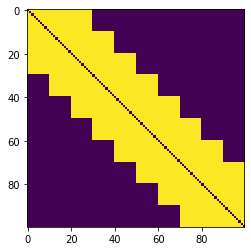

In [245]:
plt.imshow(A)

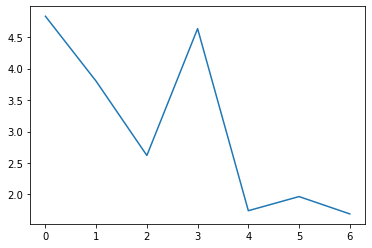

In [247]:
plt.plot(n_max_list / n_min_list)

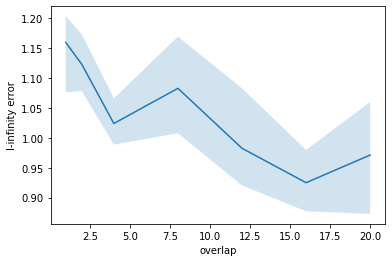

In [227]:
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(theta_list, bar_l0_beta_list[:,0], bar_l0_beta_list[:,1], alpha = 0.2)
plt.plot(theta_list, l0_beta_list)
plt.xlabel('overlap')
plt.ylabel('l-infinity error')
plt.savefig('real_island.pdf')

In [73]:
np.exp(0.1)

1.1051709180756477

In [74]:
np.exp(kappa)

9.000000000000002

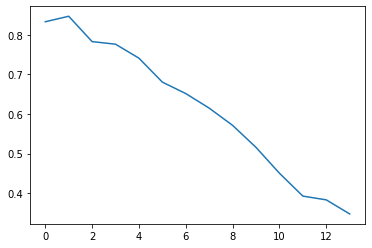

In [75]:
plt.plot(l0_beta_list)

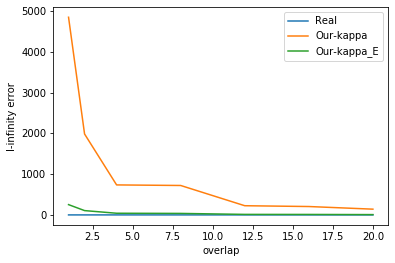

In [250]:
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(theta_list, bar_l0_beta_list[:,0], bar_l0_beta_list[:,1], alpha = 0.2)
plt.plot(theta_list, l0_beta_list)
# plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
# plt.plot(bridge_list / (n1 * n2), bound_yan_list)
plt.fill_between(theta_list, bar_our_list[:,0], bar_our_list[:,1], alpha = 0.2)
plt.plot(theta_list, bound_our_list)
plt.fill_between(theta_list, bar_our_e_list[:,0], bar_our_e_list[:,1], alpha = 0.2)
plt.plot(theta_list, bound_our_e_list)
# plt.legend(['Real','Yan','Shah','Our'])
plt.legend(['Real',
            
            'Our-kappa','Our-kappa_E'])
plt.xlabel('overlap')
plt.ylabel('l-infinity error')
plt.savefig('error_island.pdf')

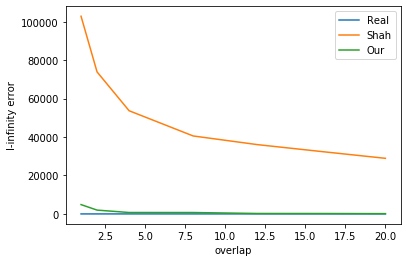

In [249]:
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(theta_list, bar_l0_beta_list[:,0], bar_l0_beta_list[:,1], alpha = 0.2)
plt.plot(theta_list, l0_beta_list)
# plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
# plt.plot(bridge_list / (n1 * n2), bound_yan_list)
plt.fill_between(theta_list, bar_shah_list[:,0], bar_shah_list[:,1], alpha = 0.2)
plt.plot(theta_list, bound_shah_list)
plt.fill_between(theta_list, bar_our_list[:,0], bar_our_list[:,1], alpha = 0.2)
plt.plot(theta_list, bound_our_list)
# plt.legend(['Real','Yan','Shah','Our'])
plt.legend(['Real','Shah','Our'])
plt.xlabel('overlap')
plt.ylabel('l-infinity error')
plt.savefig('error_island-backup.pdf')

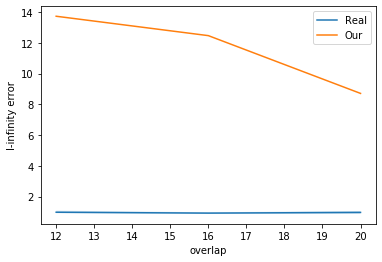

In [229]:
i = 4
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(theta_list[i:], bar_l0_beta_list[i:,0], bar_l0_beta_list[i:,1], alpha = 0.2)
plt.plot(theta_list[i:], l0_beta_list[i:])
# plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
# plt.plot(bridge_list / (n1 * n2), bound_yan_list)
# plt.plot(bridge_list / (n1 * n2), bound_shah_list)
# plt.fill_between(theta_list[i:], bar_our_list[i:,0], bar_our_list[i:,1], alpha = 0.2)
plt.fill_between(theta_list[i:], bound_our_list[i:] - std_our_list[i:], bound_our_list[i:] + std_our_list[i:], alpha = 0.2)
plt.plot(theta_list[i:], bound_our_list[i:])
# plt.legend(['Real','Yan','Shah','Our'])
plt.legend(['Real','Our'])
plt.xlabel('overlap')
plt.ylabel('l-infinity error')
plt.savefig('error_island-2.pdf')

In [217]:
std_our_list

array([9.09494702e-13, 2.27373675e-13, 1.13686838e-13, 1.13686838e-13,
       2.84217094e-14, 0.00000000e+00, 0.00000000e+00])

Text(0, 0.5, 'l-infinity error')

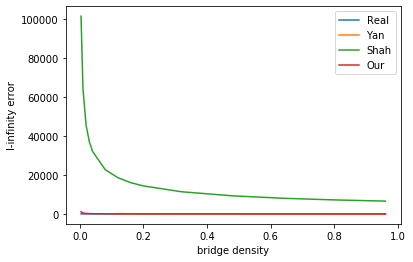

In [126]:
plt.plot(bridge_list / (n1 * n2), l0_beta_list)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
plt.legend(['Real','Yan','Shah','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

Text(0, 0.5, 'l-infinity error')

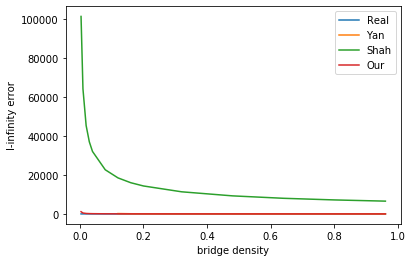

In [167]:
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l0_beta_list[:,0], bar_l0_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l0_beta_list)
plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
plt.fill_between(bridge_list / (n1 * n2), bar_shah_list[:,0], bar_shah_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.fill_between(bridge_list / (n1 * n2), bar_our_list[:,0], bar_our_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
plt.legend(['Real','Yan','Shah','Our'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

Text(0, 0.5, 'l-infinity error')

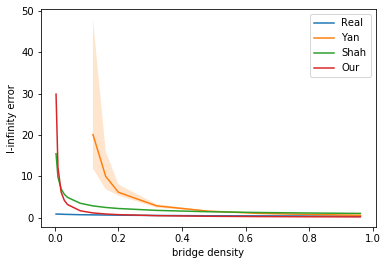

In [168]:
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l0_beta_list[:,0], bar_l0_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l0_beta_list)
plt.fill_between(bridge_list / (n1 * n2), bar_yan_nk_list[:,0], bar_yan_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_yan_nk_list)
plt.fill_between(bridge_list / (n1 * n2), bar_shah_nk_list[:,0], bar_shah_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_shah_nk_list)
plt.fill_between(bridge_list / (n1 * n2), bar_our_nk_list[:,0], bar_our_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_our_nk_list)
plt.legend(['Real','Yan','Shah','Our'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

In [77]:
len(bridge_list)

14

Text(0, 0.5, 'l-infinity error')

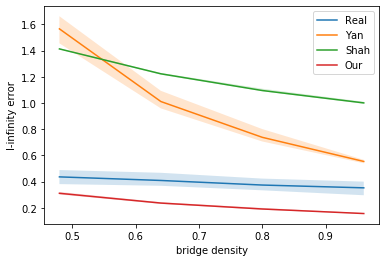

In [170]:
i = 10
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_l0_beta_list[i:,0], bar_l0_beta_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), l0_beta_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_yan_nk_list[i:,0], bar_yan_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_yan_nk_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_shah_nk_list[i:,0], bar_shah_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_shah_nk_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_our_nk_list[i:,0], bar_our_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_our_nk_list[i:])
plt.legend(['Real','Yan','Shah','Our'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

Text(0, 0.5, 'l-infinity error')

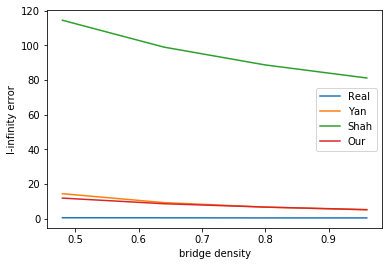

In [134]:
i = 10
plt.plot(bridge_list[i:] / (n1 * n2), l0_beta_list[i:])
plt.plot(bridge_list[i:] / (n1 * n2), bound_yan_list[i:])
plt.plot(bridge_list[i:] / (n1 * n2), bound_shah_nk_list[i:] * np.exp(2 * kappa))
plt.plot(bridge_list[i:] / (n1 * n2), bound_our_list[i:])
plt.legend(['Real','Yan','Shah','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-2.pdf')

In [148]:
n1, n2 = 50, 50
# bridge_list = np.arange(m) * 50
bridge_list = np.array([10, 25, 50, 75, 100, 200, 300, 400, 500, 800, 1200, 1600, 2000, 2400])
m = len(bridge_list)
B = 20

lam2_list = np.zeros(m)
min_n_ij_list = np.zeros(m)
n_max_list = np.zeros(m)
n_min_list = np.zeros(m)

bound_yan_list = np.zeros(m)
bound_shah_list = np.zeros(m)
bound_our_list = np.zeros(m)
bound_yan_nk_list = np.zeros(m)
bound_shah_nk_list = np.zeros(m)
bound_our_nk_list = np.zeros(m)

std_yan_list = np.zeros(m)
std_shah_list = np.zeros(m)
std_our_list = np.zeros(m)
std_yan_nk_list = np.zeros(m)
std_shah_nk_list = np.zeros(m)
std_our_nk_list = np.zeros(m)

bar_yan_list = np.zeros((m,2))
bar_shah_list = np.zeros((m,2))
bar_our_list = np.zeros((m,2))
bar_yan_nk_list = np.zeros((m,2))
bar_shah_nk_list = np.zeros((m,2))
bar_our_nk_list = np.zeros((m,2))

bound_agar_list = np.zeros(m)
std_agar_list = np.zeros(m)
bar_agar_list = np.zeros((m,2))
bound_agar_list = np.zeros(m)
std_agar_list = np.zeros(m)
bar_agar_list = np.zeros((m,2))

n = n1 + n2
# delta = np.log(n) / n
k = 10
t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta = get_beta_with_gap(n, delta)
beta *= kappa / (np.max(beta) - np.min(beta))
total = 5

w = np.exp(beta)
w /= np.sum(w)
d_avg_list = np.zeros(m)


l0_beta_list = np.zeros(m)
std_l0_beta_list = np.zeros(m)
bar_l0_beta_list = np.zeros((m,2))
rank_beta_list = np.zeros(m)
topk_beta_list = np.zeros(m)

np.random.seed(0)

for ix, bridge in enumerate(bridge_list):
    lam, n_ij = 0, 0
    
    l0_beta_, rank_beta_, topk_beta_ = np.zeros(B), np.zeros(B), np.zeros(B)
    lam2_, n_ij_, n_max_, n_min_ = np.zeros(B), np.zeros(B), np.zeros(B), np.zeros(B)
    bound_yan_, bound_shah_, bound_our_ = np.zeros(B), np.zeros(B), np.zeros(B)
    bound_yan_nk_, bound_shah_nk_, bound_our_nk_ = np.zeros(B), np.zeros(B), np.zeros(B)
    bound_agar_, bound_agar_nk_ = np.zeros(B), np.zeros(B)
    
    for b in range(B):
        A = get_barbell_adj(n1 = n1, n2 = n2, bridge = bridge)
        lam2_[b], n_ij_[b], n_max_[b], n_min_[b] = get_topo(A)
        d
        
        edge_list = get_edge(A)
        game_matrix = get_game_matrix(beta, edge_list, total)
        
        beta_hat = get_mle_reg(game_matrix)
        l0_beta_[b], rank_beta_[b], topk_beta_[b] = get_error(beta, beta_hat, k = k)
        
        L = total
        bound_yan_[b] = get_bound_yan(kappa, n_ij_[b], n, L = total)
        bound_shah_[b] = get_bound_shah(kappa, lam2_[b], n, L = total)
        bound_our_[b] = get_bound_our(kappa, lam2_[b], n_max_[b], n_min_[b], n, L)
        
        bound_yan_nk_[b] = get_bound_yan(kappa, n_ij_[b], n, L = total, no_kappa = True)
        bound_shah_nk_[b] = get_bound_shah(kappa, lam2_[b], n, L = total, no_kappa = True)
        bound_our_nk_[b] = get_bound_our(kappa, lam2_[b], n_max_[b], n_min_[b], n, L, no_kappa = True)
        
        
        
    lam2_list[ix] = np.mean(lam2_)
    min_n_ij_list[ix] = np.mean(n_ij_)
    n_max_list[ix], n_min_list[ix] = np.mean(n_max_), np.mean(n_min_)
    bound_yan_list[ix] = np.mean(bound_yan_)
    bound_shah_list[ix] = np.mean(bound_shah_)
    bound_our_list[ix] = np.mean(bound_our_)
    bound_yan_nk_list[ix] = np.mean(bound_yan_nk_)
    bound_shah_nk_list[ix] = np.mean(bound_shah_nk_)
    bound_our_nk_list[ix] = np.mean(bound_our_nk_)
    
    std_yan_list[ix] = np.std(bound_yan_)
    std_shah_list[ix] = np.std(bound_shah_)
    std_our_list[ix] = np.std(bound_our_)
    std_yan_nk_list[ix] = np.std(bound_yan_nk_)
    std_shah_nk_list[ix] = np.std(bound_shah_nk_)
    std_our_nk_list[ix] = np.std(bound_our_nk_)
    
    bar_yan_list[ix,:] = np.quantile(bound_yan_, 0.05), np.quantile(bound_yan_, 0.95)
    bar_shah_list[ix, :] = np.quantile(bound_shah_, 0.05), np.quantile(bound_shah_, 0.95)
    bar_our_list[ix, :] = np.quantile(bound_our_, 0.05), np.quantile(bound_our_, 0.95)
    bar_yan_nk_list[ix, :] = np.quantile(bound_yan_nk_, 0.05), np.quantile(bound_yan_nk_, 0.95)
    bar_shah_nk_list[ix, :] = np.quantile(bound_shah_nk_, 0.05), np.quantile(bound_shah_nk_, 0.95)
    bar_our_nk_list[ix, :] = np.quantile(bound_our_nk_, 0.05), np.quantile(bound_our_nk_, 0.95)
    
    l0_beta_list[ix] = np.mean(l0_beta_)
    std_l0_beta_list[ix] = np.std(l0_beta_)
    bar_l0_beta_list[ix, :] = np.quantile(l0_beta_, 0.05), np.quantile(l0_beta_, 0.95)
    
    rank_beta_list = np.mean(rank_beta_)
    topk_beta_list = np.mean(topk_beta_)    
    
    print(bridge / (n1 * n2))

c:\python\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
c:\python\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in double_scalars
c:\python\lib\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\python\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


0.004
0.01
0.02
0.03
0.04
0.08
0.12
0.16
0.2
0.32
0.48
0.64
0.8
0.96


In [70]:
bound_yan_list

array([          inf,           inf,           inf,           inf,
                 inf,           inf, 1297.00093616,  640.67728783,
        426.02020167,  208.47379834,  108.83084738,   72.28964191,
         52.73630414,   39.89668645])

In [71]:
delta = 1
beta = get_beta_with_gap(n, delta)
beta *= kappa / (np.max(beta) - np.min(beta))
beta

array([-1.09861229, -1.0764181 , -1.05422391, -1.03202973, -1.00983554,
       -0.98764135, -0.96544716, -0.94325298, -0.92105879, -0.8988646 ,
       -0.87667041, -0.85447622, -0.83228204, -0.81008785, -0.78789366,
       -0.76569947, -0.74350529, -0.7213111 , -0.69911691, -0.67692272,
       -0.65472854, -0.63253435, -0.61034016, -0.58814597, -0.56595179,
       -0.5437576 , -0.52156341, -0.49936922, -0.47717503, -0.45498085,
       -0.43278666, -0.41059247, -0.38839828, -0.3662041 , -0.34400991,
       -0.32181572, -0.29962153, -0.27742735, -0.25523316, -0.23303897,
       -0.21084478, -0.1886506 , -0.16645641, -0.14426222, -0.12206803,
       -0.09987384, -0.07767966, -0.05548547, -0.03329128, -0.01109709,
        0.01109709,  0.03329128,  0.05548547,  0.07767966,  0.09987384,
        0.12206803,  0.14426222,  0.16645641,  0.1886506 ,  0.21084478,
        0.23303897,  0.25523316,  0.27742735,  0.29962153,  0.32181572,
        0.34400991,  0.3662041 ,  0.38839828,  0.41059247,  0.43

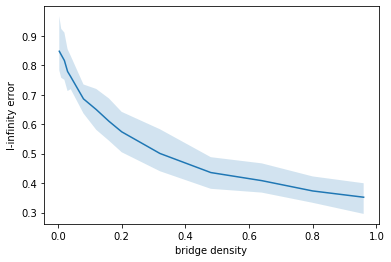

In [165]:
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l0_beta_list[:,0], bar_l0_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l0_beta_list)
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
plt.savefig('barbell-3.pdf')

In [73]:
np.exp(0.1)

1.1051709180756477

In [74]:
np.exp(kappa)

9.000000000000002

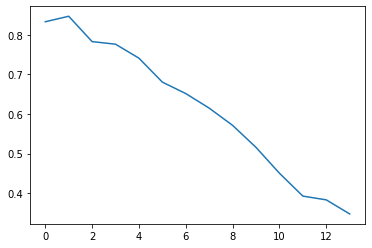

In [75]:
plt.plot(l0_beta_list)

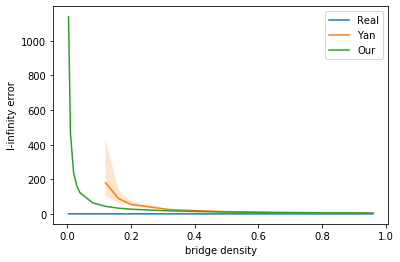

In [164]:
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l0_beta_list[:,0], bar_l0_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l0_beta_list)
plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
# plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.fill_between(bridge_list / (n1 * n2), bar_our_list[:,0], bar_our_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
# plt.legend(['Real','Yan','Shah','Our'])
plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
plt.savefig('barbell-1.pdf')

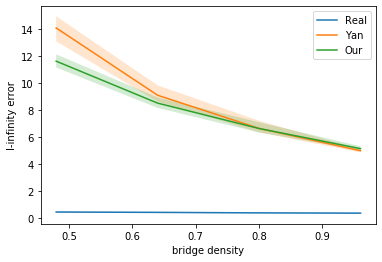

In [163]:
i = 10
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_l0_beta_list[i:,0], bar_l0_beta_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), l0_beta_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_yan_list[i:,0], bar_yan_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_yan_list[i:])
# plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_our_list[i:,0], bar_our_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_our_list[i:])
# plt.legend(['Real','Yan','Shah','Our'])
plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
plt.savefig('barbell-2.pdf')

Text(0, 0.5, 'l-infinity error')

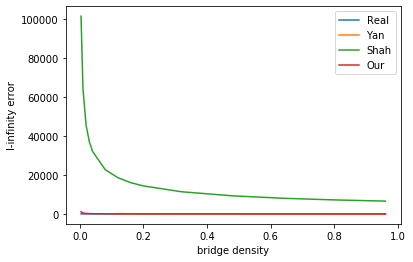

In [126]:
plt.plot(bridge_list / (n1 * n2), l0_beta_list)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
plt.legend(['Real','Yan','Shah','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

Text(0, 0.5, 'l-infinity error')

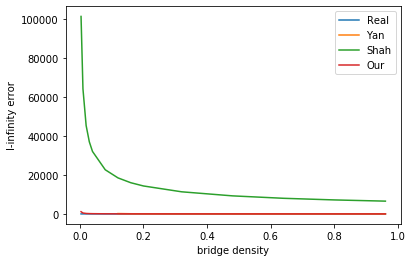

In [167]:
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l0_beta_list[:,0], bar_l0_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l0_beta_list)
plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
plt.fill_between(bridge_list / (n1 * n2), bar_shah_list[:,0], bar_shah_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.fill_between(bridge_list / (n1 * n2), bar_our_list[:,0], bar_our_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
plt.legend(['Real','Yan','Shah','Our'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

Text(0, 0.5, 'l-infinity error')

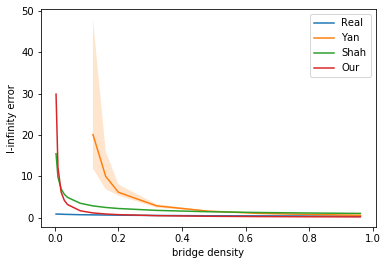

In [168]:
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l0_beta_list[:,0], bar_l0_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l0_beta_list)
plt.fill_between(bridge_list / (n1 * n2), bar_yan_nk_list[:,0], bar_yan_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_yan_nk_list)
plt.fill_between(bridge_list / (n1 * n2), bar_shah_nk_list[:,0], bar_shah_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_shah_nk_list)
plt.fill_between(bridge_list / (n1 * n2), bar_our_nk_list[:,0], bar_our_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_our_nk_list)
plt.legend(['Real','Yan','Shah','Our'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

In [77]:
len(bridge_list)

14

Text(0, 0.5, 'l-infinity error')

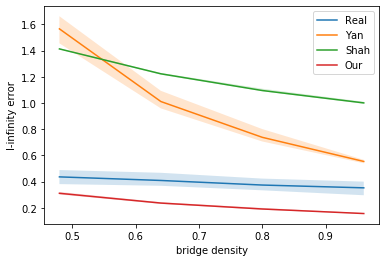

In [170]:
i = 10
# plt.fill_between(bridge_list / (n1 * n2), l0_beta_list - 2*std_l0_beta_list, l0_beta_list + 2*std_l0_beta_list, alpha = 0.2)
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_l0_beta_list[i:,0], bar_l0_beta_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), l0_beta_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_yan_nk_list[i:,0], bar_yan_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_yan_nk_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_shah_nk_list[i:,0], bar_shah_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_shah_nk_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_our_nk_list[i:,0], bar_our_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_our_nk_list[i:])
plt.legend(['Real','Yan','Shah','Our'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

Text(0, 0.5, 'l-infinity error')

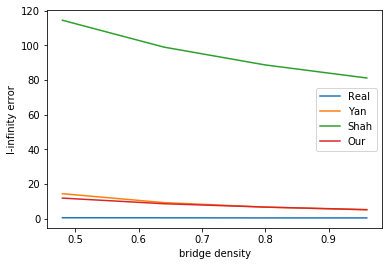

In [134]:
i = 10
plt.plot(bridge_list[i:] / (n1 * n2), l0_beta_list[i:])
plt.plot(bridge_list[i:] / (n1 * n2), bound_yan_list[i:])
plt.plot(bridge_list[i:] / (n1 * n2), bound_shah_nk_list[i:] * np.exp(2 * kappa))
plt.plot(bridge_list[i:] / (n1 * n2), bound_our_list[i:])
plt.legend(['Real','Yan','Shah','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-2.pdf')

## Regular graph, topology

In [153]:
def get_2k_regular(n, k, permute = True, info = 'adj'):
    # 2k-regular graph
    adj = np.zeros((n,n))
    for i in range(n):
        for j in range(1, k + 1):
            col = (i + j) % n
            adj[i, col] = 1
            
            col = (i - j) % n
            adj[i, col] = 1
    if permute:
        P = np.zeros((n,n))
        P[np.arange(n), np.random.permutation(n)] = 1
        adj = P.T @ adj @ P
    if info == 'adj':
        return adj
    else:
        loc = np.nonzero(adj)
        loc = set([(x,y) for x, y in zip(loc[0],loc[1])])
        return loc

In [58]:
A = get_2k_regular(10, 2, permute = False)
A

array([[0., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
       [1., 1., 0., 0., 0., 0., 0., 1., 1., 0.]])

In [55]:
A @ np.ones((10, 1))
np.ones((1,10)) @ A

array([[4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]])

In [50]:
n = 10
P = np.zeros((n,n))
P[np.arange(n), np.random.permutation(n)] = 1
P

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [223]:
def lambda2_regular_2k(n, k):
    A = get_2k_regular(n, k, permute = False, info = 'adj')
    La = np.diag(np.sum(A, axis = 0)) - A
    lambdas = np.linalg.eigvalsh(La)
    return lambdas[1], lambdas[-1]

def cos_sum(n, k):
    return 2 * k - 2 * (np.sum(np.cos(np.arange(1, k + 1) * 2 * np.pi / n)))

In [226]:
def min_n_ij(A):
    return np.min(A @ A)

In [232]:
n = 1000
k_list = np.arange(30) * 10
min_n_ij_list = []
for k in k_list:
    A = get_2k_regular(n, k, permute = False, info = 'adj')
    min_n_ij_list.append(min_n_ij(A))
min_n_ij_list = np.array(min_n_ij_list)

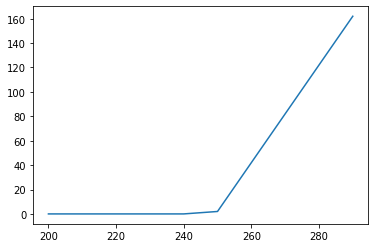

In [235]:
plt.plot(k_list[20:], min_n_ij_list[20:])

In [205]:
n = 1000
k = 120
lam2, lamn = lambda2_regular_2k(n = n, k = k)

In [224]:
n = 1000
k_list = np.arange(30) * 10
lam2_list = []
appr_list = []
for k in k_list:
    lam2, lamn = lambda2_regular_2k(n = n, k = k)
    lam2_list.append(lam2)
    appr_list.append(4 / 3 * np.pi**2 * (k)**3 / n**2)

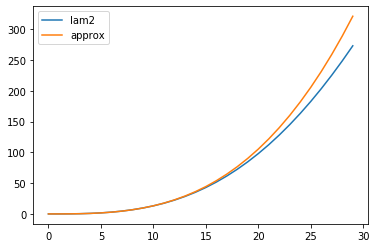

In [225]:
plt.plot(lam2_list)
plt.plot(appr_list)
plt.legend(['lam2', 'approx'])

In [217]:
n = 1000
k = 103
lam2, lamn = lambda2_regular_2k(n = n, k = k)
print(lam2)
print(4 / 3 * np.pi**2 * (k)**3 / n**2)
print(2/3 * np.pi**2 * k * (k + 1) * (2*k + 1) / n**2)
print(2 * np.pi * k**3 / n**2)

print(cos_sum(n, k))
print((2*k)**0.5)

14.284403155337708
14.379710944518894
14.589801923536749
66.65831292386824
14.284403155337941
14.352700094407323


In [62]:
n = 1000
p1 = 0.05
pn = 0.8
q = (pn / p1) ** (1/(n - 1))
p = p1 * np.exp(np.arange(n) * np.log(q))
p[-1]

0.7999999999999847

In [64]:
pv = p.reshape((n,1))
P = pv @ pv.T - np.diag(p**2)
P[:4,:4]

array([[0.        , 0.00250695, 0.00251392, 0.0025209 ],
       [0.00250695, 0.        , 0.0025209 , 0.00252791],
       [0.00251392, 0.0025209 , 0.        , 0.00253493],
       [0.0025209 , 0.00252791, 0.00253493, 0.        ]])

In [86]:
sum(p)

270.6599883067434

270.65998830674334

In [100]:
def lambda2_pq(p1, pn, n):
    q = (pn / p1) ** (1/(n - 1))
    p = p1 * np.exp(np.arange(n) * np.log(q))
    pv = p.reshape((n,1))
    La = np.sum(p) * np.diag(p) - pv @ pv.T
    lambdas = np.linalg.eigvalsh(La)
    return lambdas[1], lambdas[-1]

def n_extreme_pq(p1, pn, n):
    q = (pn / p1) ** (1/(n - 1))
    s = p1 * (q**n - 1)/(q - 1)
    return p1 * (s - p1), pn * (s - pn)

In [101]:
p1 = 0.2
pn = 0.8
n = 1000
lam2, lamn = lambda2_pq(p1 = p1, pn = pn, n = n)
n1, nn = n_extreme_pq(p1 = p1, pn = pn, n = n)

In [102]:
print(lam2, lamn)
print(n1, nn)

86.58933973530256 346.23320039671796
86.53515462770082 345.66061851080326


In [92]:
np.log(n)

6.907755278982137

In [103]:
q = (pn / p1) ** (1/(n - 1))
s = p1 * (q**n - 1)/(q - 1)

In [105]:
pn * s

346.3006185108033

In [107]:
np.sum(p)

270.6599883067434

In [106]:
np.sum(p**2)

115.17134119204752

In [80]:
A = np.random.uniform(0,1,(n,n))

In [81]:
A[A < P] = 1
A[A < 1] = 0
A = np.triu(A) + np.triu(A).T
A[-10:,-10:]

array([[0., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1., 1.],
       [1., 0., 0., 1., 1., 1., 0., 1., 1., 0.],
       [1., 0., 1., 0., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 0., 0., 1., 0., 1., 1.],
       [1., 0., 0., 1., 1., 1., 0., 0., 1., 1.],
       [1., 0., 1., 1., 1., 0., 0., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 0., 0., 1., 1., 1., 1., 1., 0.]])

In [82]:
np.sum(A) / n**2

0.072542

In [70]:
np.triu(np.ones((3,3)))

array([[1., 1., 1.],
       [0., 1., 1.],
       [0., 0., 1.]])

## K-Cayley grap

In [19]:
def get_k_regular_adj(n, k):
    # 2k-regular graph
    adj = np.zeros((n,n))
    for i in range(n):
        for j in range(1, k + 1):
            col = (i + j) % n
            adj[i, col] = 1
            
            col = (i - j) % n
            adj[i, col] = 1
    return adj
get_k_regular_adj(10,2)

array([[0., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
       [1., 1., 0., 0., 0., 0., 0., 1., 1., 0.]])

In [42]:
def get_k_regular(n, k):
    # 2k-regular graph
    adj = np.zeros((n,n))
    for i in range(n):
        for j in range(1, k + 1):
            col = (i + j) % n
            adj[i, col] = 1
            
            col = (i - j) % n
            adj[i, col] = 1
    loc = np.nonzero(adj)
    loc = set([(x,y) for x, y in zip(loc[0],loc[1])])
    return loc